In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import pickle
from pathlib import Path
from mediapipe.framework.formats import landmark_pb2
from mediapipe.framework.formats import detection_pb2

In [41]:
mp_face = mp.solutions.face_detection
mp_pose = mp.solutions.pose
mp_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [6]:
def draw_meshes(image, face_landmarks):    
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())

In [65]:
def draw_faces(image, results):
    if results.detections is None:
        return
    for detection in results.detections:
        mp_drawing.draw_detection(image, detection)
    
def draw_pose(image, results_list):
    if results.pose_landmarks is None:
        return
    for results_x in results_list:
        mp_drawing.draw_landmarks(
            image,
            results_x.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())


In [12]:

with Path("李昆澤-127844.mp.pkl").open("rb") as fin:
    data = pickle.load(fin)

In [15]:
results = data["results"]
r0 = results[0]

In [54]:
nose_tips = []
timestamps = []
for r in results:
    timestamps.append(r["offset"])
    if r["faces"] is not None:
        coord = r["faces"][0]["locationData"]["relativeKeypoints"][mp_face.FaceKeyPoint.NOSE_TIP]
        if coord["x"] < 0.5:
            nose_tips.append(coord["x"])
        else:
            nose_tips.append(float('nan'))
    else:
        nose_tips.append(float('nan'))

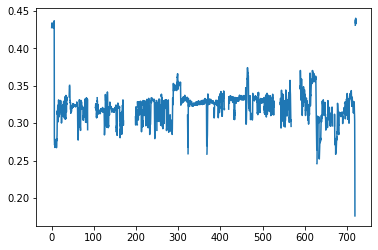

In [55]:
plt.plot(timestamps, nose_tips)

In [17]:
r0["faces"]

[{'labelId': [0],
  'score': [0.8385279],
  'locationData': {'format': 'RELATIVE_BOUNDING_BOX',
   'relativeBoundingBox': {'xmin': 0.39817378,
    'ymin': 0.25460476,
    'width': 0.060357004,
    'height': 0.10728711},
   'relativeKeypoints': [{'x': 0.4177008, 'y': 0.2855839},
    {'x': 0.43779722, 'y': 0.28821146},
    {'x': 0.42759553, 'y': 0.3139112},
    {'x': 0.43005848, 'y': 0.3352611},
    {'x': 0.4107674, 'y': 0.2964601},
    {'x': 0.45826685, 'y': 0.2985037}]}}]

In [6]:
a = {1:2}
b = {3:4}
{**a, **b}

{1: 2, 3: 4}

## Main loop

In [1]:
cap = cv2.VideoCapture("李昆澤-127844.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
# cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)
pbar = tqdm(total=n_frames)
static_image_mode = False
face_detection = mp_face.FaceDetection(model_selection=1, min_detection_confidence=0.5)
face_mesh = mp_mesh.FaceMesh(static_image_mode=static_image_mode, 
                              max_num_faces=3, refine_landmarks=True,
                              min_detection_confidence=0.5, 
                              min_tracking_confidence=0.5)
pose = mp_pose.Pose(static_image_mode=static_image_mode, 
                    model_complexity=1, 
                    enable_segmentation=True,
                    min_detection_confidence=0.5)
frame_counter = 0

results_list = []

while cap.isOpened():    
        
    success, image = cap.read()            
    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        break
    pbar.update(1)        
    
    frame_idx = cap.get(cv2.CAP_PROP_POS_FRAMES)
    ## sampling every 5 frame
    if frame_idx % 5 > 0:        
        continue    
    
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
    
    if static_image_mode:        
        ## make an image copy for visualization
        raw_image = image.copy()
    
    ## This is always true for multi-pose detection
    image.flags.writeable = True
    
    ## mediapipe processing
    face_results = face_detection.process(image)
    mesh_results = face_mesh.process(image)
    
    pose_results_list = []
    if face_results.detections:
        n_face = len(face_results.detections)
    else:
        n_face = 0
        
    for _ in range(n_face):
        pose_results = pose.process(image)
        pose_results_list.append(pose_results)
        if pose_results.segmentation_mask is not None:
            image = mask_people(image, pose_results.segmentation_mask)
        
    # Draw the face detection annotations on the image.
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    if static_image_mode:
        draw_faces(raw_image, face_results)
        draw_meshes(raw_image, mesh_results)
        draw_pose(raw_image, pose_results_list)
        break
        
    faces_dict = protobuf_to_dict(face_results.detections)
    mesh_dict = protobuf_to_dict(mesh_results.multi_face_landmarks)
    poses_dict_list = [protobuf_to_dict(x.pose_landmarks) for x in p]
    results_list.append({
        "frame": frame_idx, 
        "offset": frame_idx/fps,
        "faces": faces_dict,
        "mesh": mesh_dict,
        "poses": poses_dict_list})
    
cap.release()
face_mesh.close()
face_detection.close()
pose.close()
pbar.close()

NameError: name 'cv2' is not defined

```
## just reading frames: 2s/1000 frame
## detecting faces: 5s/1000 frame
## detecting meshes: 7s/1000 frame
## pose (w/ segmentation, model=2): 74s/1000 frame
## pose (w/o segmentation, model=2): 71s/1000 frame
## pose (w/ segmentation, model=1): 27s/1000 frame
## detect (short-ranged), mesh, pose(model=2): 83s/1000 frame
## detect (full-ranged), mesh, pose(model=2): 86s/1000 frame
## detect (full-ranged), mesh, pose(model=1): 40s/1000 frame
```

In [69]:
plt.figure(figsize=(1280/72,720/72))
plt.imshow(raw_image)

NameError: name 'raw_image' is not defined

<Figure size 1280x720 with 0 Axes>

In [70]:
from pathlib import Path
import pickle
with Path("temp_mediapipe_out.pkl").open("wb") as fout:
    pickle.dump(results_list, fout)

In [9]:
from datetime import datetime
datetime.now().strftime("v%y%m%d.%H%M%S")

'v220617.211805'